# Question 3 Flower Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".
- You only need to modify code in the "TODO" part. We added some "assertions" to check your code. **Do not** modify them.

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

You can upload your image folder on Google drive and access image folder from it. **Skip it if you run on local machine.** To mount google drive to your current colab page, use the following command 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************


C:\Users\rdesa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: CUDA not found! Training may be slow......
  import sys



## P1. Data augmentation and plotting
### TODO
- Design your image augmentation method for transform_image
- Load train and test data, and split them into train_loader and test_loader 
- Visualize your augmented image 





In [4]:
# TODO: define your image augmentation method
# Make sure to crop the image in (3,224,224) using transforms.RandomResizedCrop(224)  
transform_image = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])


# TODO: Load data using ImageFolder. Specify your image folder path 
path = "C:\\Users\\rdesa\\OneDrive\\Desktop\\Assignment5_Turn_In\\HW5\\q3_data\\flowers"
dataset = datasets.ImageFolder(path,transform=transform_image)

n = len(dataset)
n_test = int(0.1 * n) 

# Split data into features(pixels) and labels(numbers from 0 to 4)
train_dataset, test_dataset = random_split(dataset, (n-n_test,n_test))
train_loader, test_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(test_dataset, batch_size=16, shuffle=True)

(-0.5, 223.5, 223.5, -0.5)

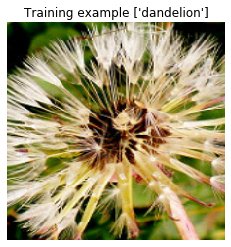

In [5]:
# Sample output
label_map = [['daisy'],['dandelion'],['rose'],['sunflower'],['tulip']]
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
assert np.array_equal(image[0].detach().numpy().shape, [3,224,224])
plt.imshow(image[0].permute(1,2,0))
plt.title(f"Training example {label_map[image[1]]}")
plt.axis('off')

## P2. Build you own CNN model 
### TODO
- Design your own model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 
- Plot your first convolution layer kernels using **plot_filters_multi_channel()**

###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- You may want to use small learning rate for training. (eg. 1e-5)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel
So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:

**stide:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll use the next structure shown in the comment:

*input -> convolution -> pooling -> fully connected -> output* \\

**Convolution #1**

16 kernels of 5x5; *Width/Height:* (224 - 5 + 2x0) / 1 + 1 = 220; *Output dimensions:* (16, 220, 220)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (220 - 2) / 2 + 1 = 110; *Output dimensions:* (16, 110, 110)

So at the end of the last convolutional layer we get a tensor of dimension (16, 110, 110). And since now we are going to feed it to fully connected classifier, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=5) 
        self.cnn2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=5) 
        self.cnn3 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=5, stride=1, padding=1)
        self.relu3 = nn.ReLU() 
        self.maxpool3 = nn.MaxPool2d(kernel_size=5)        
        self.cnn4 = nn.Conv2d(in_channels=80, out_channels=160, kernel_size=3, stride=1, padding=2)
        self.relu4 = nn.ReLU() 
        self.maxpool4 = nn.MaxPool2d(kernel_size=3)
        num_classes = 5 
        self.fc1 = nn.Linear(160,1500)
        self.fc2 = nn.Linear(1500,1000)
        self.fc3 = nn.Linear(1000,500)
        self.fc4 = nn.Linear(500,num_classes)
        
    def forward(self,x):
        x = self.cnn1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.maxpool1(x)
        #print("CNN1")
        #print(x.shape)
        x = self.cnn2(x)
        #print(x.shape)
        x = self.relu2(x)
        #print(x.shape)
        x = self.maxpool2(x)
        #print("CNN2")
        #print(x.shape)
        x = self.cnn3(x)
        #print(x.shape)
        x = self.relu3(x)
        #print(x.shape)
        x = self.maxpool3(x)
        #print(x.shape)
        #print("CNN3")
        x = self.cnn4(x)
        #print(x.shape)
        x = self.relu4(x)
        #print(x.shape)
        x = self.maxpool4(x)
        #print(x.shape)
        #print("CNN4")
        #x = self.cnn5(x)
        #print(x.shape)
        #x = self.relu5(x)
        #print(x.shape)
        #x = self.maxpool5(x)
        #print(x.shape)
        #print("CNN5")
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #x = self.fc4(x)
        out = self.fc4(x)
    
        return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [7]:
# Create CNN
device = "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 50e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [8]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data.cpu())
            iteration_list.append(count)
            accuracy_list.append(accuracy.cpu())
            print(accuracy.cpu())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

0
tensor(28.0742)
tensor(32.2506)
tensor(30.6264)
tensor(40.1392)


  5%|████▏                                                                              | 1/20 [01:24<26:42, 84.32s/it]

1
tensor(38.5151)
tensor(47.5638)
tensor(49.1879)
tensor(47.5638)
tensor(45.7077)


 10%|████████▎                                                                          | 2/20 [02:54<25:48, 86.05s/it]

2
tensor(50.1160)
Iteration: 500  Loss: 1.3326575756072998  Accuracy: 50.11600875854492 %
tensor(52.9002)
tensor(50.3480)
tensor(48.2599)
tensor(51.5081)


 15%|████████████▍                                                                      | 3/20 [04:25<24:46, 87.47s/it]

3
tensor(50.8121)
tensor(51.9722)
tensor(52.9002)
tensor(55.6845)
tensor(57.5406)


 20%|████████████████▌                                                                  | 4/20 [05:56<23:36, 88.51s/it]

4
tensor(47.0998)
Iteration: 1000  Loss: 0.9134666323661804  Accuracy: 47.099769592285156 %
tensor(59.8608)
tensor(58.4687)
tensor(59.3968)
tensor(59.6288)


 25%|████████████████████▊                                                              | 5/20 [07:26<22:15, 89.00s/it]

5
tensor(58.2367)
tensor(57.5406)
tensor(58.9327)
tensor(65.1972)
tensor(62.6450)


 30%|████████████████████████▉                                                          | 6/20 [08:56<20:52, 89.43s/it]

6
tensor(65.6613)
Iteration: 1500  Loss: 0.5248223543167114  Accuracy: 65.6612548828125 %
tensor(67.2854)
tensor(66.5893)
tensor(61.9490)
tensor(63.5731)


 35%|█████████████████████████████                                                      | 7/20 [10:26<19:23, 89.49s/it]

7
tensor(61.0209)
tensor(67.2854)
tensor(65.1972)
tensor(67.5174)


 40%|█████████████████████████████████▏                                                 | 8/20 [11:51<17:39, 88.28s/it]

8
tensor(61.4849)
tensor(64.7332)
Iteration: 2000  Loss: 0.9467145204544067  Accuracy: 64.7331771850586 %
tensor(67.0534)
tensor(69.1415)
tensor(67.5174)


 45%|█████████████████████████████████████▎                                             | 9/20 [13:21<16:14, 88.61s/it]

9
tensor(67.2854)
tensor(67.7494)
tensor(68.2135)
tensor(71.2297)
tensor(68.4455)


 50%|█████████████████████████████████████████                                         | 10/20 [14:50<14:47, 88.77s/it]

10
tensor(66.8213)
tensor(67.7494)
Iteration: 2500  Loss: 0.9420069456100464  Accuracy: 67.74942016601562 %
tensor(68.2135)
tensor(65.4292)
tensor(69.8376)


 55%|█████████████████████████████████████████████                                     | 11/20 [16:20<13:22, 89.22s/it]

11
tensor(68.9095)
tensor(70.9977)
tensor(67.0534)
tensor(72.6218)
tensor(72.1578)


 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:50<11:55, 89.46s/it]

12
tensor(67.2854)
tensor(67.7494)
Iteration: 3000  Loss: 0.9361701011657715  Accuracy: 67.74942016601562 %
tensor(70.9977)
tensor(66.8213)
tensor(70.5336)


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:20<10:26, 89.45s/it]

13
tensor(70.7657)
tensor(70.3016)
tensor(69.8376)
tensor(72.1578)
tensor(64.9652)


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [20:52<09:01, 90.32s/it]

14
tensor(67.9814)
tensor(71.6937)
Iteration: 3500  Loss: 0.5448697209358215  Accuracy: 71.69373321533203 %
tensor(73.0858)
tensor(71.6937)


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:18<07:24, 88.97s/it]

15
tensor(74.0139)
tensor(65.1972)
tensor(70.7657)
tensor(67.7494)
tensor(68.6775)


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [23:48<05:57, 89.43s/it]

16
tensor(75.4060)
tensor(70.3016)
tensor(72.6218)
Iteration: 4000  Loss: 0.6925155520439148  Accuracy: 72.62181091308594 %
tensor(69.1415)
tensor(70.3016)


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:18<04:28, 89.62s/it]

17
tensor(70.9977)
tensor(68.6775)
tensor(72.3898)
tensor(74.7100)
tensor(71.9258)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [26:49<03:00, 90.09s/it]

18
tensor(71.9258)
tensor(72.3898)
tensor(68.9095)
Iteration: 4500  Loss: 0.5167238712310791  Accuracy: 68.90951538085938 %
tensor(76.5661)
tensor(74.9420)


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:20<01:30, 90.29s/it]

19
tensor(67.9814)
tensor(77.9582)
tensor(77.7262)
tensor(72.3898)
tensor(74.4780)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [29:51<00:00, 89.56s/it]


In [9]:
print(accuracy_list)

[tensor(28.0742), tensor(32.2506), tensor(30.6264), tensor(40.1392), tensor(38.5151), tensor(47.5638), tensor(49.1879), tensor(47.5638), tensor(45.7077), tensor(50.1160), tensor(52.9002), tensor(50.3480), tensor(48.2599), tensor(51.5081), tensor(50.8121), tensor(51.9722), tensor(52.9002), tensor(55.6845), tensor(57.5406), tensor(47.0998), tensor(59.8608), tensor(58.4687), tensor(59.3968), tensor(59.6288), tensor(58.2367), tensor(57.5406), tensor(58.9327), tensor(65.1972), tensor(62.6450), tensor(65.6613), tensor(67.2854), tensor(66.5893), tensor(61.9490), tensor(63.5731), tensor(61.0209), tensor(67.2854), tensor(65.1972), tensor(67.5174), tensor(61.4849), tensor(64.7332), tensor(67.0534), tensor(69.1415), tensor(67.5174), tensor(67.2854), tensor(67.7494), tensor(68.2135), tensor(71.2297), tensor(68.4455), tensor(66.8213), tensor(67.7494), tensor(68.2135), tensor(65.4292), tensor(69.8376), tensor(68.9095), tensor(70.9977), tensor(67.0534), tensor(72.6218), tensor(72.1578), tensor(67.285

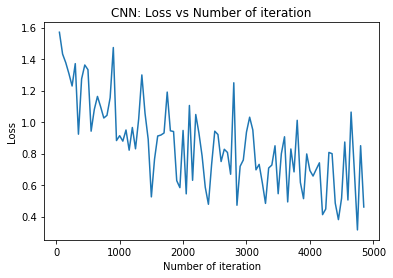

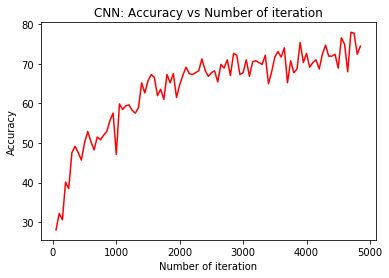

In [10]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

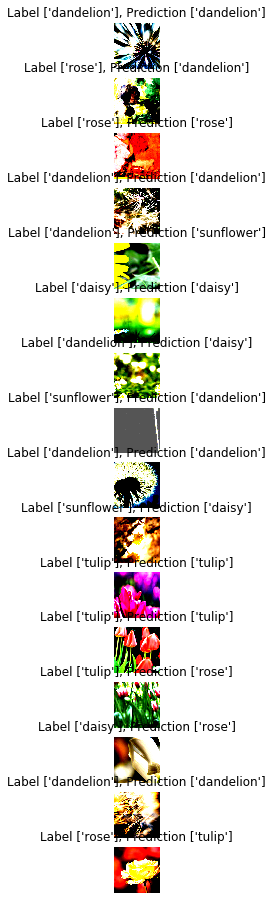

In [11]:
# Evaluate your model
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = len(labels)
fig = plt.figure(figsize=(num_cols,num_rows))
for idx in range(num_rows):
  ax1 = fig.add_subplot(num_rows,num_cols,idx+1)
  img = images.cpu().detach()[idx].numpy()
  img = (img - np.mean(img)) / np.std(img)
  img = np.minimum(1, np.maximum(0, (img + 0.5)))
  ax1.imshow(img.transpose((1,2,0)))
  
  ax1.set_title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")
  ax1.axis('off')
plt.savefig('Prediction.png', dpi=100)    
plt.show()

### Visualizing your first layer filter 

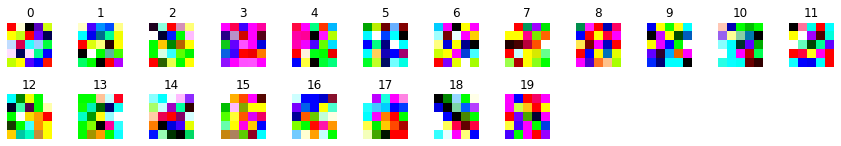

In [12]:
# plot your first layer kernels 

def plot_filters_multi_channel(t):
    #make sure the input channel is 3 
    assert(t.shape[1]==3)

    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12

    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().detach().numpy(), np.float32)
        
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('Filter.png', dpi=100)    
    plt.tight_layout()
    plt.show()

plot_filters_multi_channel(list(model.parameters())[0])